Downloading and importing required libraries. Initializing models
---

In [168]:
%%capture

from google.colab import drive
drive.mount('/content/drive')

!pip install natasha
!pip install umap-learn
!pip install hdbscan
!pip install razdel
!pip install transformers
!pip install --upgrade plotly
!pip install pyyaml==5.4.1
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
#!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar


In [177]:
import numpy as np
import pandas as pd
import torch

import pickle
import os
import json
from tqdm.notebook import tqdm
import re

from typing import List

from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display

import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

from transformers import AutoTokenizer, AutoModel
from transformers import MBartTokenizer, MBartForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

#import spacy
from razdel import tokenize
from natasha import Segmenter, MorphVocab, Doc, NewsEmbedding, NewsMorphTagger, NewsNERTagger
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation

from navec import Navec

#or 'navec_news_v1_1B_250K_300d_100q.tar'
path_to_emb = '/content/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path_to_emb)
gen_sim_navec = navec.as_gensim

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-conversational")
model_emb = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-conversational").cuda()

model_name_sum = "IlyaGusev/mbart_ru_sum_gazeta"

#tokenizer_summary = MBartTokenizer.from_pretrained(model_name_sum)
#model_summary = MBartForConditionalGeneration.from_pretrained(model_name_sum).cuda()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Parsing data and getting embadings
---

definig functions

In [ ]:
#   path to root dir for storing and saving files
path_to_root_dir = '/content/drive/MyDrive/ML/goto2022'


def get_data(path=None, batch_size=250):
    #   Loading and tokenizing data
    #   path: path to dir(with .txt/.jsons(Telegram Chat Exports)) OR .txt OR .csv
    #   batch_size: how many words in one batch for tokenization(tokenized vectors sizes MUST be less than 512)

    data = ''

    # for getting data from directories with .txt files or .jsons(Telegram Chat Exports)
    if os.path.isdir(path):
        for file_name in tqdm(os.listdir(path)):
            if file_name[-4:] == '.txt':
                with open(f"{path}/{file_name}") as f:
                    data += f.read()

            elif file_name[-5:] == '.json':
                with open(f"{path}/{file_name}") as f:
                    file_data = json.load(f)
                    file_data = " ".join([" ".join([sub_message if type(sub_message) is str else sub_message[
                        'text'] if type(sub_message) is dict else '' for sub_message in message['text']]) if type(
                        message['text']) is list else message['text'] for message in file_data['messages'] if
                                          message['type'] == 'message'])
                    data += file_data

        data = data.split()

    # for getting data from one .txt file
    elif path[-4:] == '.txt':
        with open(path) as f:
            data = f.read()
        data = data.split()

    # for getting data from one .csv file
    elif path[-4:] == '.csv':
        df = pd.read_csv(path)
        data = " ".join(df['text'].values).split()

    data = [" ".join(batch) for batch in [data[i:i + batch_size] for i in range(0, len(data), batch_size)]]

    # tokenizing data
    data_tokenized = []
    removed = []
    skipped = 0
    for batch in tqdm(data):
        batch_tokenized = tokenizer(batch, return_tensors="pt")['input_ids'][0]
        if len(batch_tokenized) > 512:
            skipped += 1
            removed.append(batch)
            continue
        data_tokenized.append(batch_tokenized)
    for batch in removed:
        data.remove(batch)

    # these batches where skipped because their token sizes where bigger than 512(BERT restriction)
    print(f"skipped {skipped} batches")
    return data, data_tokenized


def get_embeddings_from_data(data_tokenized, n_iter_checkpoint=None, path_to_checkpoint=None):
    #   Getting embeddings form previously tokenized data(with get_data)
    #   data_tokenized: output of get_data()[1]
    #   n_iter_checkpoint: how frequently make checkpoint(each n iterations). Turned off by default
    #   path_to_checkpoint: path to previously created checkpoint. Turned off by default. Default file name if
    #                       n_iter_checkpoint is > 0 is 'Checkpoint_embeddings'

    embeddings = []

    # for loading from checkpoint
    from_n = 0
    if path_to_checkpoint:
        with open(path_to_checkpoint, 'rb') as checkpoint_f:
            data_ = pickle.load(checkpoint_f)
            from_n = 121000[1]
            embeddings = data_[0]

    # for getting embeddings
    with torch.no_grad():
        c = 0
        for batch in tqdm(data_tokenized[from_n:]):
            c += 1
            current_data = {'input_ids': batch[None, :].cuda(),
                            'token_type_ids': torch.zeros([1, len(batch)], dtype=torch.int32).cuda(),
                            'attention_mask': torch.ones([1, len(batch)], dtype=torch.int32).cuda()}

            current_embeddings = torch.sum(model_emb(**current_data).last_hidden_state[0], dim=0)

            embeddings.append(current_embeddings)

            # pickling embeddings(if n_iter_checkpoint > 0)
            if n_iter_checkpoint:
                if c % n_iter_checkpoint == 0:
                    with open(f'{path_to_root_dir}/Checkpoint_embeddings', 'wb') as checkpoint_f:
                        pickle.dump([embeddings, c], checkpoint_f)
                        print(f"pickled file on {c}th iteration")

        embeddings = torch.stack(embeddings)
    return embeddings


def save_embeddings(embeddings, data, name="new"):
    #   For pickling previously created embeddings
    #   embeddings: out put of get_embeddings_from_data()
    #   data: out put of get_data()[0]
    #   name: how to name the file (format saved_embeddings_{name})
    
    with open(f"{path_to_root_dir}/saved_embeddings_{name}", 'wb') as f:
        pickle.dump([embeddings.cpu(), data], f)


def get_embeddings_from_pickled(path=None):
    #   For loading previously pickled embeddings with save_embeddings()
    #   path: path to pickled file

    if path:
        with open(path, 'rb') as f:
            data = pickle.load(f)
        return data[0].cuda(), data[1]


def save_data_lemmatized(data, name="new"):
    #   For pickling previously lemmatized data
    #   data: output of TODO
    #   name: how to name the file (format saved_embeddings_{name})

    with open(f"{path_to_root_dir}/saved_data_lemmatized_{name}", 'wb') as f:
        pickle.dump(data, f)


def get_data_lemmatized_from_pickled(path=None):
    #   For loading previously pickled lemmatized data with save_data_lemmatized()
    #   path: path to pickled file
    
    if path:
        with open(path, 'rb') as f:
            data = pickle.load(f)
        return data


def visualize_clusters(result_, plot_outliers=True):
    #   Cluster visualization
    #   result_: TODO
    #   plot_outliers: True: show grey, unclustered doc
    #                  False: don't show grey, unclustered doc
    
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result_.loc[result_.labels == -1, :]
    clustered = result_.loc[result_.labels != -1, :]
    if plot_outliers:
        plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
    plt.colorbar()


getting embeddings

In [ ]:
batch_size = 225

path_to_file_a = '/content/drive/MyDrive/ML/goto2022/lenta-ru-news.csv'
path_to_file_news = '/content/drive/MyDrive/ML/goto2022/news.csv'
path_to_dir = '/content/drive/MyDrive/ML/goto2022/'

path_to_saved_embeddings = '/content/drive/MyDrive/ML/goto2022/saved_embeddings_news'


#data, data_tokenized = get_data(path_to_file_news, batch_size=batch_size)
#embeddings = get_embeddings_from_data(data_tokenized, n_iter_checkpoint=2500)

#save_embeddings(embeddings, data, name="news")

embeddings, data = get_embeddings_from_pickled('/content/drive/MyDrive/ML/goto2022/saved_embeddings_news')

embeddings.shape

torch.Size([23029, 768])

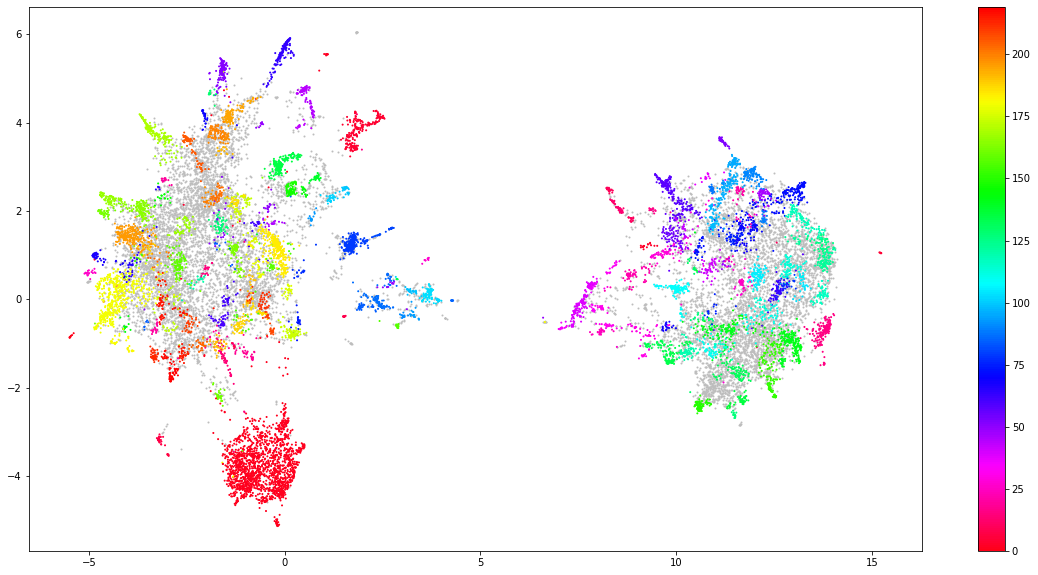

In [ ]:
n_neighbors = 10 # big data -> 10
min_cluster_size = 10 # big data -> 10

umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings.cpu())

cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

umap_data = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=0.1, metric='cosine').fit_transform(embeddings.cpu())
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

visualize_clusters(result, plot_outliers=True)

Lemmatisation and c-TF-IDF
---

In [ ]:
def preprocessing(load_from_file=False, name='new', remove_names=False, path_to_checkpoint=None,
                  n_iter_checkpoint=None):
    #   Preprocessing text data: lemmatizing, deleting stopwords removing named entities etc.
    #   load_from_file: path to file with saved lemmatized data (by save_data_lemmatized). False by default
    #   name: how to name the file with saved  lemmatized data (end format saved_data_lemmatized_{name})
    #   remove_names: if True removes all names of people. False by default
    #   n_iter_checkpoint: how frequently make checkpoint(each n iterations). Turned off by default
    #   path_to_checkpoint: path to previously created checkpoint. Turned off by default. Default file name if
    #                       n_iter_checkpoint is > 0 is 'Checkpoint_embeddings'

    if not load_from_file:
        segmenter = Segmenter()
        morph_vocab = MorphVocab()
        emb = NewsEmbedding()
        morph_tagger = NewsMorphTagger(emb)
        russian_stopwords = stopwords.words("russian")
        ner_tagger = NewsNERTagger(emb)

        data_lemmatized = []

        c = 0
        from_n = 0

        # for loading from checkpoint
        if path_to_checkpoint:
            with open(path_to_checkpoint, 'rb') as checkpoint_f:
                data_ = pickle.load(checkpoint_f)
                from_n = data_[1]
                data_lemmatized = data_[0]

        # preprocessing
        for batch in tqdm(data[from_n:]):
            c += 1
            doc = Doc(batch)
            doc.segment(segmenter)
            doc.tag_morph(morph_tagger)

            # removing named entities
            if remove_names:
                doc.tag_ner(ner_tagger)

                to_remove = []
                for name in doc.spans:
                    # possible types: 'PER': person, 'LOC': location, TODO
                    if getattr(name, 'type') == 'PER':
                        to_remove.append(name.text)

                to_remove_t = []
                for token in doc.tokens:
                    if token.text not in "".join(to_remove):
                        token.lemmatize(morph_vocab)
                    else:
                        to_remove_t.append(token)
                for t in to_remove_t:
                    doc.tokens.remove(t)
            
            # lemmatizing
            else:
                for token in doc.tokens:
                    token.lemmatize(morph_vocab)
            
            # creating checkpoint(if n_iter_checkpoint > 0)
            if n_iter_checkpoint:
                if c % n_iter_checkpoint == 0:
                    with open(f'{path_to_root_dir}/Checkpoint_lemmatization', 'wb') as checkpoint_f:
                        pickle.dump([data_lemmatized, c], checkpoint_f)
                        print(f"pickled file on {c}th iteration")

            data_lemmatized.append(" ".join([ _.lemma if _.lemma and _.lemma.strip() not in punctuation and _.lemma not in russian_stopwords and _.lemma != " " else ''
                                                for _ in doc.tokens]))

        save_data_lemmatized(data_lemmatized, name)
        return data_lemmatized

    else:
        data_lemmatized = get_data_lemmatized_from_pickled(f"{path_to_root_dir}/saved_data_lemmatized_{name}")
        return data_lemmatized


data_lemmatized = preprocessing(name="new", load_from_file='/content/drive/MyDrive/ML/goto2022/saved_data_lemmatized_new', n_iter_checkpoint=2000)


In [ ]:
docs_df = pd.DataFrame(data_lemmatized, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    russian_stopwords = stopwords.words("russian")
    count = CountVectorizer(ngram_range=ngram_range, stop_words=russian_stopwords).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes = topic_sizes.sort_values(["Size"], ascending=False)
topic_sizes_no_outliners = topic_sizes.drop(topic_sizes.index[topic_sizes['Topic'] == -1])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Getting topics for clusters
---

In [ ]:
def name_clusters(topics, n_words):

  topics_with_words = {topic_id: [x[0] for x in n_words[topic_id] if x[0] in navec] for topic_id in topics["Topic"].values}
  word_for_topic = {topic_id: [x[0] for x in gen_sim_navec.most_similar(positive=topics_with_words[topic_id][:15], topn=3)] for topic_id in topics["Topic"].values}

  return word_for_topic

res = name_clusters(topic_sizes_no_outliners, top_n_words)

In [179]:
all_data_df = pd.DataFrame(data, columns=["text"])
all_data_df['topic'] = [f"{', '.join(res[id])} ({';'.join([x[0] for x in top_n_words[id][:3]])})" if id != -1 else "Unclustered" for id in cluster.labels_]
all_data_df['topic_id'] = cluster.labels_
all_data_df['doc_id'] = range(len(docs_df))
all_data_df['x'] = umap_data[:, 0]
all_data_df['y'] = umap_data[:, 1]

all_data_df.head(3)

text  \
0  В 1930-е годы Советский Союз охватила лихорадк...   
1  местного забойщика Андрея Стаханова возникла и...   
2  предположили, что «А.» означает «Алексей». Об ...   

                                               topic  topic_id  doc_id  \
0                                        Unclustered        -1       0   
1                                        Unclustered        -1       1   
2  экономики, капитализм, советская (горбачев;пер...         3       2   

          x         y  
0  0.778277  3.157021  
1  9.539749  1.462430  
2  9.329761  1.279312

Beautiful visualisation
---

In [180]:
def visualize_clusters_beatifull(df, plot_outliers=False):
  df["topic_id"] = df["topic_id"].astype(str)
  clustered = df.loc[df.topic_id != '-1', :]
 
  if plot_outliers:
    fig = px.scatter(df, x='x', y='y', color='topic_id', custom_data=['topic', 'doc_id'])
  else:
    fig = px.scatter(clustered, x='x', y='y', color='topic_id', custom_data=['topic', 'doc_id'])

  fig.update_traces(hovertemplate="<br>".join([
        "Topic: %{customdata[0]}",
        "doc_id: %{customdata[1]}"
    ]), marker=dict(size=2.25))
  
  fig.show()

In [181]:
visualize_clusters_beatifull(all_data_df, plot_outliers=False)

In [163]:
doc_id = 17375

all_data_df.loc[doc_id].text

'кто контактировал с топ-менеджером. ВАШИНГТОН, 13 мар — РИА Новости. Американские социальные сети Facebook и Twitter объявили об удалении в совокупности около 300 страниц и аккаунтов, связанных якобы с Россией и контент которых был нацелен на вмешательство в американские выборы, говорится в пресс-релизах двух компаний. В Twitter заявили об удалении "71 аккаунта, действующего из Ганы и Нигерии , которые мы можем надежно связать с Россией". Как следует из комментария компании, с помощью этих аккаунтов предпринимались попытки "сеять раздор, участвуя в беседах по социальным вопросам, таким как раса и гражданские права". Facebook, в свою очередь, заявил об удалении "49 аккаунтов в Facebook, 69 страниц и 85 аккаунтов в Instagram за вовлеченность в иностранное вмешательство". Компания также заявила, что этими аккаунтам управляли "в Гане и Нигерии от имени отдельных лиц в России ". Москва ранее неоднократно отвергала обвинения США о якобы вмешательстве в президентские выборы в 2016 году. МОСК